### Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types.

The dataset contains 9 sub-directories in each train and test subdirectories.

The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
!ls

gdrive	sample_data


In [5]:
!ls gdrive/"My Drive"/IIITB_Assignments_Data/Melanoma_Detection_Assignment

'Skin cancer ISIC The International Skin Imaging Collaboration'


In [6]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
# Printing the count of images in each directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


## Loading data using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Training Data Set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Validation Data Set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# Listing out all the classes of skin cancer and storing it in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualisation

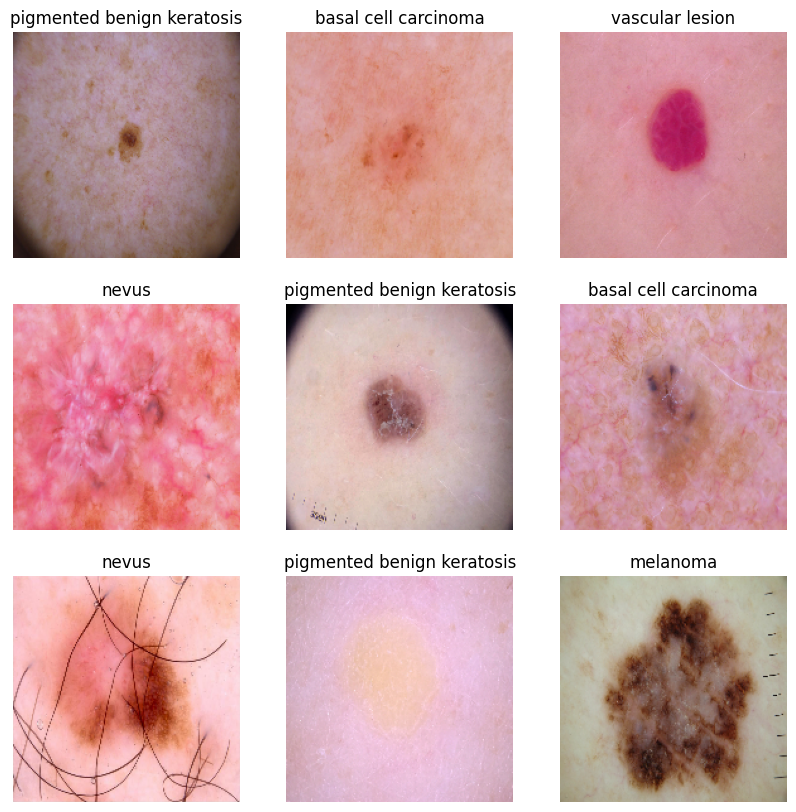

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`.

This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB).

The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating Model

1. Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`
2. Choose an appropriate optimiser and loss function for model training
Train the model for ~20 epochs
3. Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

In [15]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 243s 968ms/step - loss: 1.9102 - accuracy: 0.2963 - val_loss: 1.7976 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5864 - accuracy: 0.4509 - val_loss: 1.4961 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4043 - accuracy: 0.5223 - val_loss: 1.3314 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2568 - accuracy: 0.5547 - val_loss: 1.4064 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1442 - accuracy: 0.5915 - val_loss: 1.4117 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.0141 - accuracy: 0.6518 - val_loss: 1.3536 - val_accuracy: 0.5548
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 0.9214 - accuracy: 0.6713 - val_loss: 1.4029 - val_accuracy: 0.5526
Epoch 8/20

### Visualizing training resultså

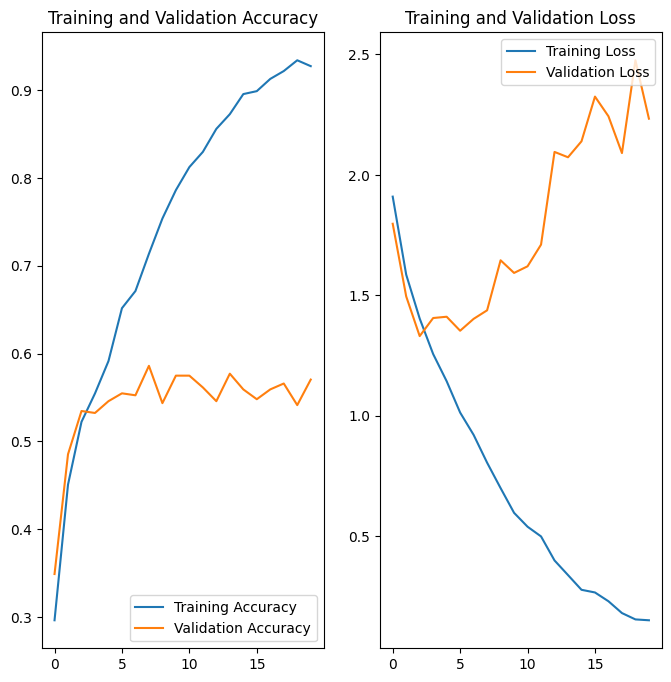

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings from model

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process.

Also, the difference in accuracy between training and validation accuracy is noticeable.

Model is overfitting

#### As model is overfitting we would need to augument the data

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

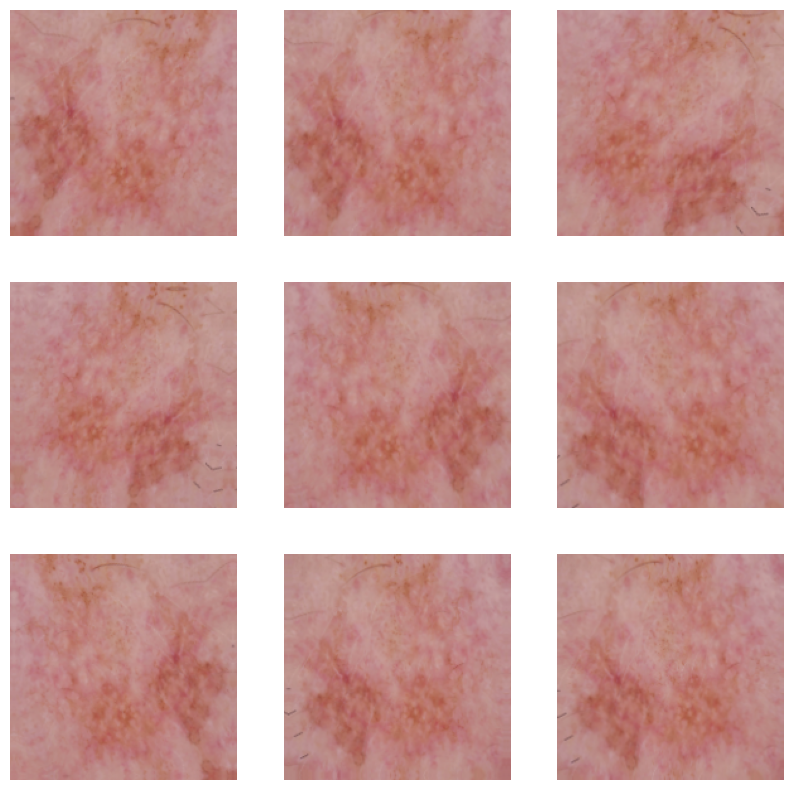

In [21]:
# Visualizing augmentation strategy, if works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Creating new model, compiling and train the model


In [22]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 37ms/step - loss: 2.0467 - accuracy: 0.2288 - val_loss: 1.8855 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.8781 - accuracy: 0.2930 - val_loss: 1.7776 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6380 - accuracy: 0.4224 - val_loss: 1.5376 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4810 - accuracy: 0.4860 - val_loss: 1.5246 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4783 - accuracy: 0.4727 - val_loss: 1.4229 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4019 - accuracy: 0.5033 - val_loss: 1.5057 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.3575 - accuracy: 0.5190 - val_loss: 1.5991 - val_accuracy: 0.4497
Epoch 8/20
56

### Visualizing the results

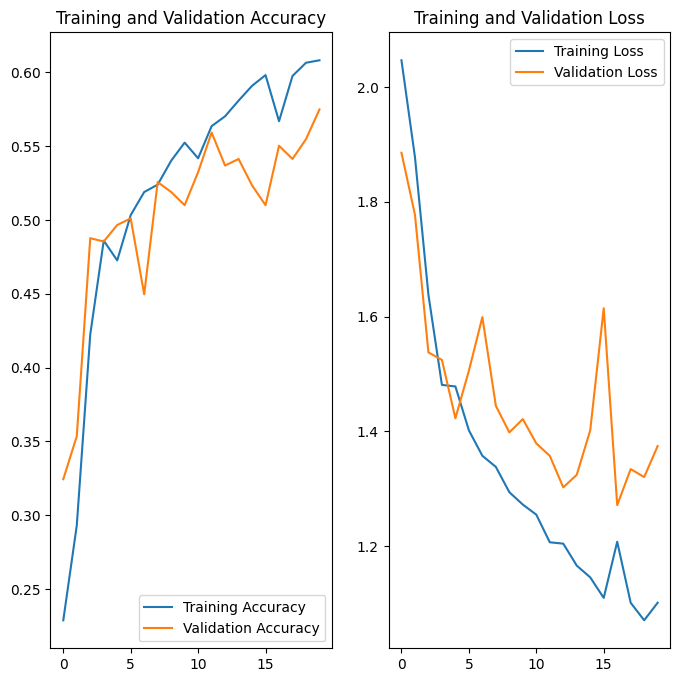

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the plots above, the training & validation accuracy is increasing linearly.

Also, the difference in accuracy between training and validation accuracy is noticeable but is much better than earlier model.

We can consider model to be working ok.

### Checking disribution of classes in dataset to check on class imbalance

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [27]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,nevus
1,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,nevus
2,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,nevus
3,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,nevus
4,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,nevus
...,...,...
2234,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,vascular lesion
2235,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,vascular lesion
2236,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,vascular lesion
2237,gdrive/My Drive/IIITB_Assignments_Data/Melanom...,vascular lesion


Class=4 (nevus), n=357 (15.945%)
Class=2 (dermatofibroma), n=95 (4.243%)
Class=7 (squamous cell carcinoma), n=181 (8.084%)
Class=5 (pigmented benign keratosis), n=462 (20.634%)
Class=3 (melanoma), n=438 (19.562%)
Class=1 (basal cell carcinoma), n=376 (16.793%)
Class=6 (seborrheic keratosis), n=77 (3.439%)
Class=0 (actinic keratosis), n=114 (5.092%)
Class=8 (vascular lesion), n=139 (6.208%)


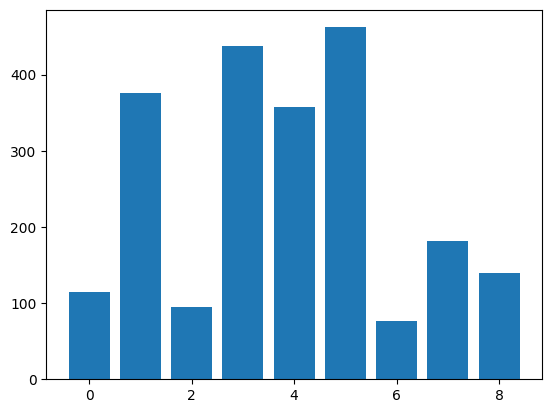

In [28]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Get class names
class_names = label_encoder.classes_

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d (%s), n=%d (%.3f%%)' % (k, class_names[k], v, per))

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

seborrheic keratosis is having lesser number of images

pigmented benign keratosis is having most number of images


### Rectifying the class imbalance

In [29]:
!pip install Augmentor

Using following procedure for agumentor

1. Instantiating a `Pipeline` object pointing to a directory containing initial image data set.<br>
2. Defining a number of operations to perform on data set using `Pipeline` object.<br>
3. Executing these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
data_dir_train

PosixPath('gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [31]:
path_to_training_dataset = str(data_dir_train)+"/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E13607AFD00>: 100%|██████████| 500/500 [00:23<00:00, 20.87 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E13607C75E0>: 100%|██████████| 500/500 [00:22<00:00, 21.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E13607451E0>: 100%|██████████| 500/500 [00:30<00:00, 16.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E136076F130>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7E136064A440>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E1360663DF0>: 100%|██████████| 500/500 [00:19<00:00, 25.58 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E1360793100>: 100%|██████████| 500/500 [00:44<00:00, 11.29 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1416E40BE0>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1368128220>: 100%|██████████| 500/500 [00:18<00:00, 26.38 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types..
Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000556.jpg_e126bda6-e08d-40b3-8a9c-cdb8f44ed5aa.jpg',
 'gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028820.jpg_5ecc19e6-26f7-49e9-a0ff-ddb7fdd92240.jpg',
 'gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000475.jpg_f34376dd-6bcc-44b8-92a8-9fd4585067c7.jpg',
 'gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000461.jpg_02ad5148-9b78-4cb8-bc23-206078cf0012.jpg',
 'gdrive/My Drive/IIITB_Assignments_Data/Melanoma_Detection_Assignment/Skin cancer ISIC The 

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-36-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance, we can add more images as we want to improve training process.

#### Training model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### Create training dataset

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating model


In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compiling model

In [42]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [43]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

#### Training model

In [44]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/30
169/169 [==============================] - 50s 117ms/step - loss: 2.0674 - accuracy: 0.1862 - val_loss: 1.7612 - val_accuracy: 0.2635 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 11s 64ms/step - loss: 1.7281 - accuracy: 0.3336 - val_loss: 1.6203 - val_accuracy: 0.3571 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 11s 66ms/step - loss: 1.5867 - accuracy: 0.3889 - val_loss: 1.5344 - val_accuracy: 0.3912 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 11s 63ms/step - loss: 1.5181 - accuracy: 0.4004 - val_loss: 1.4331 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 11s 63ms/step - loss: 1.4725 - accuracy: 0.4297 - val_loss: 1.4194 - val_accuracy: 0.4343 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 11s 63ms/step - loss: 1.4447 - accuracy: 0.4327 - val_loss: 1.3301 - val_accuracy: 0.4796 - lr: 0.0010
Epoch 7/30
169/169 [==============================] - 11s

#### Visualizing the model results

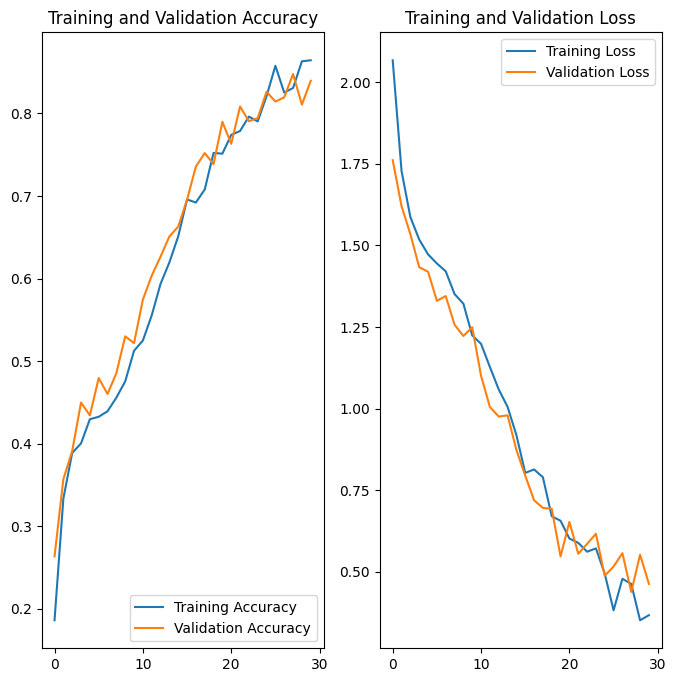

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy and validation accuracy are almost same. This is a sign of good fit.

The training loss and validation loss are almost same. This is a sign of good fit.

The Validation accuracy is 0.86 which is good. The model is able to classify the images with 86% accuracy.

### Testing the model

1/1 [==============================] - 0s 279ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


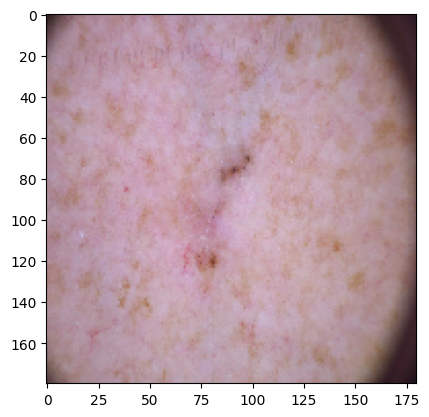

In [46]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)